# MuNRa / Cosmic Watch — EDA (Muon Detector)

**Goal:** build a reusable, professional EDA workflow for MuNRa/Cosmic Watch event logs.

**Rules (applied here):**
- Column names stay neutral until supported by **(a)** functional evidence (ranges/patterns) **and** (b) documentation.
- `data/raw/*` is never edited. We analyze **processed** data only.
- This notebook is written to work with *any* dataset from the same detector format (same column count).

---

In [14]:
# Setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams["figure.dpi"] = 120

# Robust repo-root detection:
# - If you run from repo root -> BASE_DIR = cwd
# - If you run from notebooks/    -> BASE_DIR = parent of notebooks
cwd = Path.cwd().resolve()
BASE_DIR = cwd if (cwd / "data").exists() else cwd.parent

PROCESSED_CSV = BASE_DIR / "data" / "processed" / "munra_clean.csv"

CFG = {
    # "high-signal" here means "upper-tail by signal_proxy" (statistical split, not a physical claim)
    "high_signal_quantile": 0.95,
    # plots
    "bins": 40,
    "alpha": 0.75,
    "grid_alpha": 0.35,
    # zoom: computed from background distribution
    "zoom_quantile": 0.99,
}

In [15]:
# Load processed dataset (dataset-agnostic)
assert PROCESSED_CSV.exists(), f"Missing file: {PROCESSED_CSV}"

df = pd.read_csv(PROCESSED_CSV)

print("shape:", df.shape)
print("columns:", df.columns.tolist())
print("NaNs total:", int(df.isna().sum().sum()))
df.head(5)

shape: (304, 10)
columns: ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9']
NaNs total: 0


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,38,14086,82,680,0.6,72983.7,29.4,41853,0,COSMIC
1,39,14318,85,1921,1.1,72983.7,29.4,5474,0,COSMIC
2,42,14701,140,3144,1.9,72984.7,29.4,5489,0,COSMIC
3,43,15231,80,1557,0.9,72982.0,29.4,41814,0,COSMIC
4,44,15858,79,881,0.6,72984.7,29.4,41862,0,COSMIC


In [16]:
# Basic integrity checks (keep these light but strict)
assert df.shape[1] == 10, f"Expected 10 columns, got {df.shape[1]}"
assert int(df.isna().sum().sum()) == 0, "Unexpected NaNs in processed dataset"

# Convenience: detect which column is constant string label (often 'COSMIC')
const_obj = [c for c in df.columns if df[c].dtype == "object" and df[c].nunique() == 1]
print("constant object columns:", const_obj)

constant object columns: ['col_9']


## 1) Functional profiling (no physics)

We start with **patterns** only:
- monotonic counters / timestamps
- constant or near-constant readings
- ADC-like ranges (e.g., 0–4095)


In [17]:
def monotonic_hint(s: pd.Series) -> str:
    if not pd.api.types.is_numeric_dtype(s):
        return "n/a"
    if s.is_monotonic_increasing and not s.is_monotonic_decreasing:
        return "increasing"
    if s.is_monotonic_decreasing and not s.is_monotonic_increasing:
        return "decreasing"
    return "not_monotonic"

def zero_frac(s: pd.Series) -> float | None:
    if not pd.api.types.is_numeric_dtype(s):
        return None
    return float((s == 0).mean())

def near_constant_hint(s: pd.Series) -> str:
    if not pd.api.types.is_numeric_dtype(s):
        if s.nunique() == 1:
            return f"constant({s.iloc[0]})"
        return "varies"
    nun = s.nunique()
    if nun == 1:
        return f"constant({s.iloc[0]})"
    if nun <= 3:
        return f"low_cardinality(n={nun})"
    # near-constant heuristic: small range relative to median magnitude
    rng = float(s.max() - s.min())
    if rng <= 0.2 and float(s.median()) > 0:
        return f"near_constant(range={rng:.3g})"
    return "varies"

summary_rows = []
for c in df.columns:
    s = df[c]
    row = {
        "col": c,
        "dtype": str(s.dtype),
        "nunique": int(s.nunique()),
        "min": float(s.min()) if pd.api.types.is_numeric_dtype(s) else None,
        "max": float(s.max()) if pd.api.types.is_numeric_dtype(s) else None,
        "%zeros": (zero_frac(s) * 100) if zero_frac(s) is not None else None,
        "monotonic": monotonic_hint(s),
        "const_hint": near_constant_hint(s),
    }
    summary_rows.append(row)

pd.DataFrame(summary_rows)

,col,dtype,nunique,min,max,%zeros,monotonic,const_hint
0,col_0,int64,304,38.0,343.0,0.0,increasing,varies
1,col_1,int64,304,14086.0,126498.0,0.0,increasing,varies
2,col_2,int64,94,76.0,3962.0,0.0,not_monotonic,varies
3,col_3,int64,272,602.0,4095.0,0.0,not_monotonic,varies
4,col_4,float64,46,0.5,953.6,0.0,not_monotonic,varies
5,col_5,float64,71,72982.0,72998.0,0.0,not_monotonic,varies
6,col_6,float64,2,29.4,29.5,0.0,not_monotonic,low_cardinality(n=2)
7,col_7,int64,243,5301.0,149430.0,0.0,not_monotonic,varies
8,col_8,int64,1,0.0,0.0,100.0,not_monotonic,constant(0)
9,col_9,object,1,NaN,NaN,NaN,n/a,constant(COSMIC)


## 2) Rename (optional, justified)

If you want prettier plots/variables, we can rename columns **only when the mapping is supported by evidence**.

Below is a conservative rename used in this project.  
It can be adjusted if your detector firmware outputs a different ordering.

> Note: names like `adc_*` are *instrument* names (not physics claims).


In [18]:
# Conservative rename mapping (based on observed patterns + common MuNRa/Cosmic Watch schema)
rename_map = {
    "col_0": "event_id",          # monotonic event counter
    "col_1": "timestamp_raw",     # monotonic time-like counter (units unknown here)
    "col_2": "adc_low_gain",      # ADC-like channel (not necessarily low gain until confirmed)
    "col_3": "adc_high_gain",     # ADC-like channel with 4095 saturation events
    "col_4": "signal_proxy",      # derived or scaled amplitude-like value (units unknown)
    "col_5": "pressure_raw",      # near-constant + matches common sensor magnitude; confirm with docs
    "col_6": "temperature_raw",   # near-constant around room temp
    "col_7": "dead_time_raw",     # time-between-events-like field; scale mismatch must be checked
    "col_8": "coincidence_flag",  # constant 0 in this dataset
    "col_9": "event_type",        # constant label in this dataset
}

df_r = df.rename(columns=rename_map).copy()
df_r.head(3)

,event_id,timestamp_raw,adc_low_gain,adc_high_gain,signal_proxy,pressure_raw,temperature_raw,dead_time_raw,coincidence_flag,event_type
0,38,14086,82,680,0.6,72983.7,29.4,41853,0,COSMIC
1,39,14318,85,1921,1.1,72983.7,29.4,5474,0,COSMIC
2,42,14701,140,3144,1.9,72984.7,29.4,5489,0,COSMIC


In [19]:
# Quick evidence checks for key renamed fields
print("event_id increasing:", df_r["event_id"].is_monotonic_increasing)
print("timestamp_raw increasing:", df_r["timestamp_raw"].is_monotonic_increasing)
print("temperature unique:", sorted(df_r["temperature_raw"].unique())[:10])
print("event_type unique:", df_r["event_type"].unique())
print("coincidence_flag unique:", df_r["coincidence_flag"].unique())

event_id increasing: True
timestamp_raw increasing: True
temperature unique: [np.float64(29.4), np.float64(29.5)]
event_type unique: ['COSMIC']
coincidence_flag unique: [0]


## 3) Signal channels: range + saturation

We test the **ADC hypothesis** (instrument-level):
- 12-bit ADC max is often 4095
- saturation is a strong signature of an ADC ceiling


In [20]:
def adc_edge_counts(series: pd.Series, edge: int = 4095) -> dict:
    return {
        "min": float(series.min()),
        "max": float(series.max()),
        "nunique": int(series.nunique()),
        "count==0": int((series == 0).sum()),
        f"count=={edge}": int((series == edge).sum()),
    }

print("adc_low_gain:", adc_edge_counts(df_r["adc_low_gain"]))
print("adc_high_gain:", adc_edge_counts(df_r["adc_high_gain"]))
print("signal_proxy:", {"min": float(df_r["signal_proxy"].min()), "max": float(df_r["signal_proxy"].max()), "nunique": int(df_r['signal_proxy'].nunique())})

adc_low_gain: {'min': 76.0, 'max': 3962.0, 'nunique': 94, 'count==0': 0, 'count==4095': 0}
adc_high_gain: {'min': 602.0, 'max': 4095.0, 'nunique': 272, 'count==0': 0, 'count==4095': 16}
signal_proxy: {'min': 0.5, 'max': 953.6, 'nunique': 46}


In [21]:
# High-signal split (statistical tail, not a physical claim)
thr = df_r["signal_proxy"].quantile(CFG["high_signal_quantile"])
df_r["high_signal"] = df_r["signal_proxy"] >= thr

bg = df_r[~df_r["high_signal"]]
hi = df_r[df_r["high_signal"]]

sat = (df_r["adc_high_gain"] == 4095)

print("Events:", len(df_r))
print(f"High-signal quantile: q={CFG['high_signal_quantile']:.2f}")
print("Threshold (signal_proxy):", float(thr))
print("High-signal events:", int(df_r["high_signal"].sum()), f"({df_r['high_signal'].mean():.3f})")
print("")
print("High-gain saturation (adc_high_gain==4095):")
print("- All:", int(sat.sum()), f"({sat.mean():.3f})")
print("- High-signal:", int((sat & df_r['high_signal']).sum()), f"({sat[df_r['high_signal']].mean():.3f})")
print("- Background:", int((sat & ~df_r['high_signal']).sum()), f"({sat[~df_r['high_signal']].mean():.3f})")

Events: 304
High-signal quantile: q=0.95
Threshold (signal_proxy): 4.224999999999983
High-signal events: 16 (0.053)

High-gain saturation (adc_high_gain==4095):
- All: 16 (0.053)
- High-signal: 16 (1.000)
- Background: 0 (0.000)


In [22]:
# Plot helper (reusable)
def overlay_hist(ax, x_bg, x_hi, bins=40, title="", xlabel="", ylabel="Events", logy=False):
    ax.hist(x_bg, bins=bins, alpha=CFG["alpha"], label="Background")
    ax.hist(x_hi, bins=bins, alpha=CFG["alpha"], label="High-signal tail")
    if logy:
        ax.set_yscale("log")
        ylabel = ylabel + " (log scale)"
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=CFG["grid_alpha"])

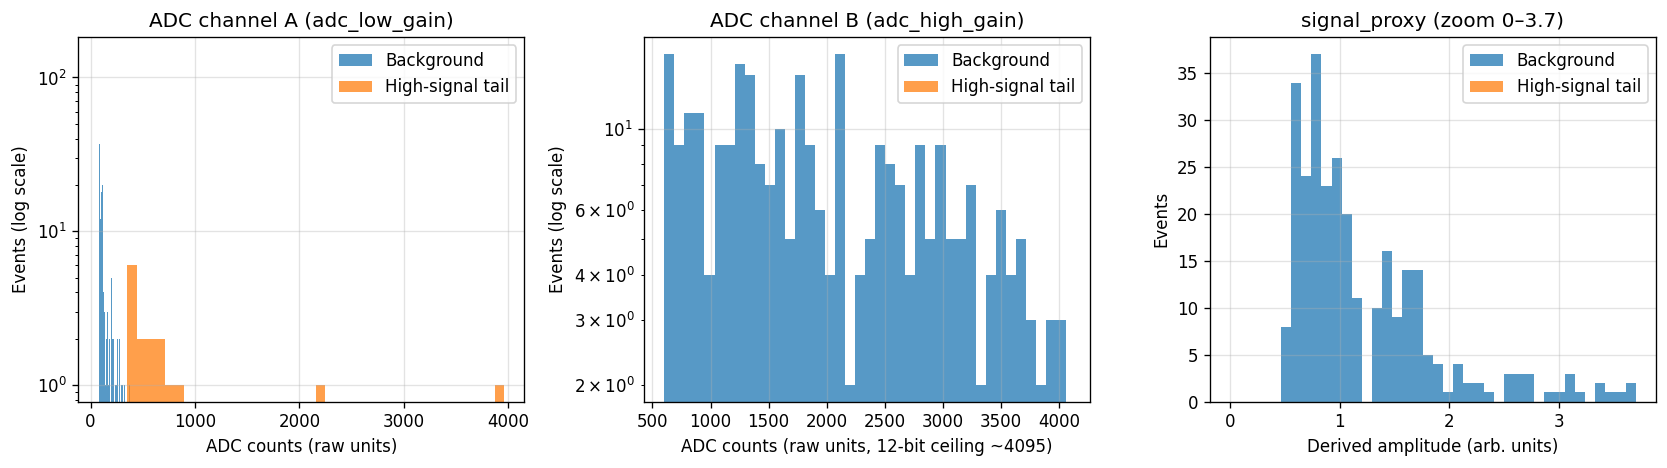

In [23]:
# Signal plots (clear axes)
fig, axes = plt.subplots(1, 3, figsize=(14,4))

overlay_hist(
    axes[0],
    bg["adc_low_gain"],
    hi["adc_low_gain"],
    bins=CFG["bins"],
    title="ADC channel A (adc_low_gain)",
    xlabel="ADC counts (raw units)",
    logy=True,
)

overlay_hist(
    axes[1],
    bg["adc_high_gain"],
    hi["adc_high_gain"],
    bins=CFG["bins"],
    title="ADC channel B (adc_high_gain)",
    xlabel="ADC counts (raw units, 12-bit ceiling ~4095)",
    logy=True,
)

# signal_proxy: zoom + full range (auto zoom)
zoom_max = float(bg["signal_proxy"].quantile(CFG["zoom_quantile"]))
zoom_max = max(zoom_max, float(bg["signal_proxy"].min()))

axes[2].hist(bg["signal_proxy"], bins=CFG["bins"], range=(0, zoom_max), alpha=CFG["alpha"], label="Background")
axes[2].hist(hi["signal_proxy"], bins=CFG["bins"], range=(0, zoom_max), alpha=CFG["alpha"], label="High-signal tail")
axes[2].set_title(f"signal_proxy (zoom 0–{zoom_max:.3g})")
axes[2].set_xlabel("Derived amplitude (arb. units)")
axes[2].set_ylabel("Events")
axes[2].legend()
axes[2].grid(True, alpha=CFG["grid_alpha"])

plt.tight_layout()
plt.show()

## 4) Timing sanity (units may differ)

We compare:
- `diff(timestamp_raw)` (increments of the time-like counter)
- `dead_time_raw` (time-since-previous-event-like field)

If these are in different units/scales, direct subtraction will be invalid.


In [24]:
dt = df_r["timestamp_raw"].diff().dropna()

print("timestamp_raw increments summary:")
display(dt.describe())

print("dead_time_raw summary:")
display(df_r["dead_time_raw"].describe())

ratio_med = float(df_r["dead_time_raw"].median() / dt.median())
ratio_mean = float(df_r["dead_time_raw"].mean() / dt.mean())

print("Scale comparison:")
print("median(dead_time_raw) / median(diff(timestamp_raw)) =", ratio_med)
print("mean(dead_time_raw) / mean(diff(timestamp_raw))     =", ratio_mean)
print("Fraction where dead_time_raw > diff(timestamp_raw):", float((df_r.loc[dt.index, "dead_time_raw"] > dt).mean()))

timestamp_raw increments summary:


count     303.000000
mean      370.996700
std       374.133361
min         6.000000
25%       100.000000
50%       242.000000
75%       546.000000
max      2155.000000
Name: timestamp_raw, dtype: float64

dead_time_raw summary:


count       304.000000
mean      32657.851974
std       30376.918905
min        5301.000000
25%        5525.750000
50%       41574.000000
75%       41747.250000
max      149430.000000
Name: dead_time_raw, dtype: float64

Scale comparison:
median(dead_time_raw) / median(diff(timestamp_raw)) = 171.79338842975207
mean(dead_time_raw) / mean(diff(timestamp_raw))     = 88.02733825593634
Fraction where dead_time_raw > diff(timestamp_raw): 1.0


In [25]:
# Normalized dead-time (keeps raw data intact; adds a derived column)
# This makes dead_time comparable to timestamp increments *for internal consistency checks only*.
dead_time_norm = df_r["dead_time_raw"] / ratio_med
df_r["dead_time_norm"] = dead_time_norm

print("dead_time_norm summary:")
display(df_r["dead_time_norm"].describe())

delta_t_total = float(df_r["timestamp_raw"].iloc[-1] - df_r["timestamp_raw"].iloc[0])
T_dead_norm = float(df_r["dead_time_norm"].sum())
T_live_norm = delta_t_total - T_dead_norm

print("Timing (normalized units):")
print("Δt_total =", delta_t_total)
print("T_dead_norm =", T_dead_norm)
print("T_live_norm =", T_live_norm)
print("Dead fraction =", T_dead_norm / delta_t_total)

dead_time_norm summary:


count    304.000000
mean     190.099586
std      176.822398
min       30.856834
25%       32.165091
50%      242.000000
75%      243.008479
max      869.823928
Name: dead_time_norm, dtype: float64

Timing (normalized units):
Δt_total = 112412.0
T_dead_norm = 57790.27406552172
T_live_norm = 54621.72593447828
Dead fraction = 0.5140934603558492


In [26]:
# Live-time corrected rate (in raw time-units; interpret units after documentation)
N_events = len(df_r)
raw_rate = N_events / delta_t_total
live_rate = N_events / T_live_norm

print(f"Raw rate  (events / time-unit): {raw_rate:.4e}")
print(f"Live rate (events / time-unit): {live_rate:.4e}")
print(f"Rate correction factor (live/raw): {live_rate / raw_rate:.3f}")

Raw rate  (events / time-unit): 2.7043e-03
Live rate (events / time-unit): 5.5656e-03
Rate correction factor (live/raw): 2.058


## 5) Outlier inspection (small and explicit)

Outliers are **rare events** that may be:
- true high-amplitude detections, or
- saturated/edge cases, or
- data artifacts

We do **not** drop them by default. We only *inspect* them.


In [27]:
# Identify top-K by signal_proxy and show relevant fields
TOPK = min(10, len(df_r))
cols_show = ["event_id", "timestamp_raw", "adc_low_gain", "adc_high_gain", "signal_proxy", "dead_time_raw", "pressure_raw", "temperature_raw"]

df_r.sort_values("signal_proxy", ascending=False).head(TOPK)[cols_show]

,event_id,timestamp_raw,adc_low_gain,adc_high_gain,signal_proxy,dead_time_raw,pressure_raw,temperature_raw
106,146,49147,3962,4095,953.6,77692,72985.6,29.4
48,88,27692,2217,4095,228.5,5720,72986.8,29.4
80,120,39279,834,4095,12.7,77701,72993.1,29.4
75,115,37454,752,4095,10.7,5447,72986.8,29.4
78,118,38148,665,4095,8.8,5439,72989.9,29.4
271,311,116548,640,4095,8.4,41852,72989.7,29.5
114,154,50813,605,4095,7.7,5390,72991.0,29.4
277,317,117226,581,4095,7.3,5405,72991.8,29.4
297,337,124819,511,4095,6.3,5348,72993.4,29.5
274,314,117104,506,4095,6.2,5516,72991.8,29.4


## Conclusions (technical, defensible)

- The dataset contains **304 single-event records** with a monotonic event counter and a monotonic time-like counter.
- Two numeric channels behave like **ADC readings**, and one channel saturates at **4095** in a small fraction of events.
- A **high-signal tail (~5%)** is robustly identified using a quantile threshold on `signal_proxy`.
- In this dataset, **all saturated high-gain events belong to the high-signal tail**, and none occur in the background.
- The timing-related fields show a **scale mismatch**; unit reconciliation requires firmware/docs before physical live-time claims.

## Next steps
1. Confirm column semantics and units against detector documentation / firmware output.
2. If available, analyze coincidence-enabled data (non-zero `coincidence_flag`).
3. Add calibration/validation runs to convert ADC/proxy values into physical units.
